In [2]:
import os
import functools
import operator
import subprocess
from typing import Annotated, Sequence, TypedDict
from typing import Literal
from dotenv import load_dotenv
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_ollama import ChatOllama
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
)
!pip install langchain_experimental
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import ToolNode
from langchain_experimental.utilities import PythonREPL

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from dotenv import load_dotenv


load_dotenv()

False

### Local LLM 

In [3]:
from langchain_ollama import ChatOllama
local_llm = 'qwen2.5:14b'

llm = ChatOllama(
    model=local_llm,
    temperature=0,
)

### Tool 정의

In [5]:
!pip install langchain_tavily langchain_experimental
!pip install numexpr pint
from typing import Annotated
import pint
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain.agents import Tool
from langchain.chains.llm_math.base import LLMMathChain

# 웹 크롤링을 위한 Tool 정의
tavily_tool = TavilySearch(max_results=5)

# 파이썬 코드를 실행할 수 있는 Tool 정의
repl = PythonREPL()

@tool
def python_repl_tool(code: Annotated[str, "Python code to execute"]):
    """Execute arbitrary Python code in an isolated REPL.
    - Use print(...) to show outputs (stdout is captured and returned).
    - Return the stdout or the repr of the last expression.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"```python\n{code}\n```\nStdout: {result}"

# 수학 계산 Tool 정의
math_tool = Tool(
    name="Calculator",
    func=LLMMathChain.from_llm(llm=llm).run,
    description="Useful for when you need to answer questions about math. \
    The input should be a math question or expression, and the output will be the numerical answer."
)

# 번역 Tool 정의
@tool("tavlatools.translate_text")
def translation_tool(
    text: Annotated[str, "The text to translate."],
    target_language: Annotated[str, "Target language, e.g., 'Korean', 'English', 'Spanish'."]
):
    """Translate the given text into the specified target language."""
    prompt = f"Translate the following text into {target_language}:\n\n{text}"
    return llm.invoke(prompt).content

# 단위 변환 Tool 정의
ureg = pint.UnitRegistry()
@tool
def unit_conversion_tool(
    expression: Annotated[str, "Unit conversion expression, e.g., '10 km to miles'."]
):
    """Convert values between units. Supports length, mass, time, temperature, etc."""
    try:
        # 예: "10 km to miles"
        value, _, target = expression.partition(" to ")
        qty = ureg.Quantity(value.strip())
        result = qty.to(target.strip())
        return f"{result.magnitude} {result.units}"
    except Exception as e:
        return f"Failed to convert units. Error: {repr(e)}"
    
tools = [tavily_tool, python_repl_tool, math_tool, translation_tool, unit_conversion_tool]


   ------------------------------ --------- 3/4 [pint]
   ---------------------------------------- 4/4 [pint]



### 그래프 State 및 Assistant 노드 정의

In [6]:
from typing import Annotated, List
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.mro

        Args:
            runnable (Runnable): The runnable instance to invoke.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Call method to invoke the LLM and handle its responses.
        Re-prompt the assistant if the response is not a tool call or meaningful text.

        Args:
            state (State): The current state containing messages.
            config (RunnableConfig): the configureation for the runnable.

        Returns:
            dict: The final state containing the updated messages.
        """

        while True:
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                    or isinstance(result.content, list)
                    and not result.content[0]. get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


### Assistant 프롬프트 정의

In [7]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a tool-using assistant. Available tools: "
            "tavily_search, python_repl_tool, Calculator, translation_tool, unit_conversion_tool.\n"
            "ROUTING: "
            "- Web info or fact-checking -> tavily_search"
            "- Math -> Calculator"
            "- Python code / charts -> python_repl_tool (print outputs)"
            "- Translation -> translation_tool"
            "- Unit conversion -> unit_conversion_tool"
            "POLICY: "
            "- Use the tools to process the request step by step."
            "- If a tool fails, try a simpler call or another tool."
            "- When you have the final answer, respond with:"
            "  FINAL ANSWER: <your answer>"
            "  and stop."
        ),
        ("placeholder", "{messages}"),
    ]
)
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

### Tool Node 함수 정의 및 에러 예외 처리

In [8]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes"
            )
            for tc in tool_calls
        ]
    }


### 그래프 정의하기

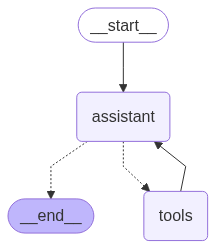

In [9]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

try:
    display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass


### 여러 가지 Task로 Graph 테스트하기

#### 그래프 그리기

Python REPL can execute arbitrary code. Use with caution.


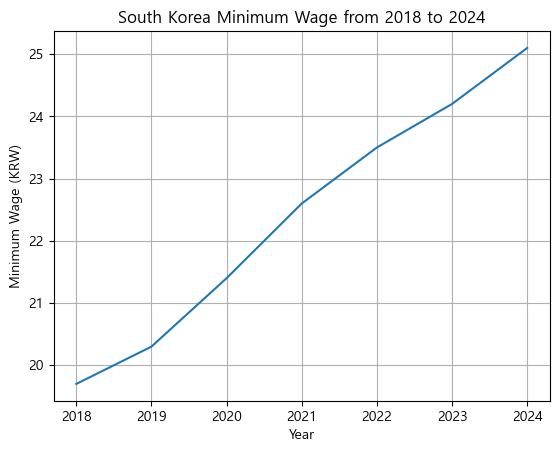


--- Event ---
{'assistant': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-09-02T08:03:03.8838687Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4006640900, 'load_duration': 74242300, 'prompt_eval_count': 2064, 'prompt_eval_duration': 835704500, 'eval_count': 222, 'eval_duration': 3088565000, 'model_name': 'qwen2.5:14b'}, id='run--01d5e050-38ff-422a-a828-fbecf22b4411-0', tool_calls=[{'name': 'tavily_search', 'args': {'end_date': '2024-12-31', 'query': '대한민국의 2018년 ~ 2024년 최저시급 데이터', 'start_date': '2018-01-01'}, 'id': '1e1bcb80-a00a-456e-9ef4-41beeae35ba4', 'type': 'tool_call'}, {'name': 'python_repl_tool', 'args': {'code': "import matplotlib.pyplot as plt; years = [str(year) for year in range(2018, 2025)]; minimum_wages = [19.7, 20.3, 21.4, 22.6, 23.5, 24.2, 25.1]; plt.plot(years, minimum_wages); plt.xlabel('Year'); plt.ylabel('Minimum Wage (KRW)'); plt.title('South Korea Minimum Wage from 2018 to 2024

In [14]:
import uuid

def predict_react_agent_answer_verbose(example: dict):
    """Show step-by-step LangGraph execution"""
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    events = react_graph.stream(
        {"messages": [("user", example["input"])]},
        config,
    )

    for event in events:
        print("\n--- Event ---")
        print(event)   # 여기서 event["messages"] / event["state"] 등 확인 가능

    return {"final_state": event}

example = {"input": 
                "user"
                "대한민국의 2018년 ~ 2024년 최저시급에 대한 데이터를 찾아줘,"
                "그리고 수집한 데이터에 대한 matplotlib 그래프를 그려줘,"
                "그래프를 다 그렸다면 종료(FINAL ANWSER)해줘.",

        }

response = predict_react_agent_answer_verbose(example)
print(response['final_state']['assistant']['messages'].content)

#### 번역하기

In [15]:
example = {"input": 
                "user"
                "'안녕하세요, 좋은 아침이에요'를 스페인어로 번역해줘"
        }

response = predict_react_agent_answer_verbose(example)
print(response['final_state']['assistant']['messages'].content)


--- Event ---
{'assistant': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-09-02T08:03:18.7193999Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1469238800, 'load_duration': 56295800, 'prompt_eval_count': 2025, 'prompt_eval_duration': 785641700, 'eval_count': 40, 'eval_duration': 618068400, 'model_name': 'qwen2.5:14b'}, id='run--d4d2fcf8-7dc2-4792-be39-3b14e678af8e-0', tool_calls=[{'name': 'tavlatools.translate_text', 'args': {'target_language': 'Spanish', 'text': '안녕하세요, 좋은 아침이에요'}, 'id': '0ecae213-6cb6-48a0-a663-54facf671476', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2025, 'output_tokens': 40, 'total_tokens': 2065})}}

--- Event ---
{'tools': {'messages': [ToolMessage(content='La traducción al español de "안녕하세요, 좋은 아침이에요" que en coreano significa "Hello, have a good morning", sería:\n\n"Hola, que tengas un buen día por la mañana". \n\nSin embargo, es importante notar que una versión más

#### 단위 변환

In [16]:
example = {"input": 
                "user"
                "'1Kg은 몇 파운드야 '"
        }

response = predict_react_agent_answer_verbose(example)
print(response['final_state']['assistant']['messages'].content)


--- Event ---
{'assistant': {'messages': AIMessage(content=' iNdEx="unit_conversion_tool"\n iNdEx="expression":"1 Kg to pounds"\n"ичество\n', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-09-02T08:03:24.3176341Z', 'done': True, 'done_reason': 'stop', 'total_duration': 841440000, 'load_duration': 55035500, 'prompt_eval_count': 2013, 'prompt_eval_duration': 32509300, 'eval_count': 42, 'eval_duration': 740091200, 'model_name': 'qwen2.5:14b'}, id='run--04bafd14-4c86-497c-a0ce-073783622999-0', tool_calls=[{'name': 'unit_conversion_tool', 'args': {'expression': '1 kg to pounds'}, 'id': '10a330c5-1e08-4eda-ba50-c79996a957e7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2013, 'output_tokens': 42, 'total_tokens': 2055})}}

--- Event ---
{'tools': {'messages': [ToolMessage(content='2.2046226218487757 pound', name='unit_conversion_tool', id='5d2dbe02-7d9b-47f8-ad93-f57b63dccc97', tool_call_id='10a330c5-1e08-4eda-ba50-c79996a957e7')]}}

--- Event 

# 실습 문제: email 보내는 툴을 Tools 노드에 추가해서 자신의 이메일로 메일 보내기

### 이메일 송신자 정보 입력

In [ ]:
# Gmail 앱 비밀번호 설정
GMAIL_APP_PASSWORD = ""
SENDER_EMAIL = ""

### 이메일 툴 정의

In [ ]:
import os
import re
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from typing import Optional, Annotated
EMAIL_REGEX = re.compile(r"^[^@\s]+@[^@\s]+\.[^@\s]+$")

@tool("send_email")
def send_gmail_tool(
    to: Annotated[str, "수신자 이메일 주소"],
    subject: Annotated[str, "메일 제목"],
    body: Annotated[str, "메일 본문(plain text)"],
    sender_email: Annotated[Optional[str], "발신자 주소. 미지정 시 전역/환경변수 사용"]=None,
    app_password: Annotated[Optional[str], "Gmail 앱 비밀번호. 미지정 시 전역/환경변수 사용"]=None,
) -> dict:
    """
    Gmail SMTP를 사용해 간단한 텍스트 메일을 발송합니다.
    - 인증 정보는 (인자) → (전역변수 SENDER_EMAIL/GMAIL_APP_PASSWORD) → (동일 이름 환경변수) 순으로 해석됩니다.
    - 성공/실패 여부와 상세 메시지를 JSON(dict)로 반환합니다.
    """
    # 입력 검증
    if not EMAIL_REGEX.match(to):
        return {"success": False, "detail": f"잘못된 수신자 주소 형식: {to}"}

    sender, password = [SENDER_EMAIL, GMAIL_APP_PASSWORD]
    if not sender or not EMAIL_REGEX.match(sender):
        return {"success": False, "detail": "발신자 주소가 설정되지 않았거나 형식이 잘못되었습니다."}
    if not password:
        return {"success": False, "detail": "GMAIL_APP_PASSWORD(앱 비밀번호)가 설정되지 않았습니다."}

    # 메시지 구성
    message = MIMEMultipart()
    message["From"] = sender
    message["To"] = to
    message["Subject"] = subject
    message.attach(MIMEText(body, "plain"))

    # 발송
    try:
        server = smtplib.SMTP("smtp.gmail.com", 587, timeout=30)
        server.starttls()
        server.login(sender, password)
        server.sendmail(sender, to, message.as_string())
        return {"success": True, "detail": "이메일 발송 성공"}
    except Exception as e:
        return {"success": False, "detail": f"발송 실패: {repr(e)}"}
    finally:
        try:
            server.quit()
        except Exception:
            pass
tools.append(send_gmail_tool)

### 프롬프트에 Email Tool 관련 내용 추가

In [ ]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a tool-using assistant. Available tools: "
            "tavily_search, python_repl_tool, Calculator, translation_tool, unit_conversion_tool.\n"
            "ROUTING: "
            "- Web info or fact-checking -> tavily_search"
            "- Math -> Calculator"
            "- Python code / charts -> python_repl_tool (print outputs)"
            "- Translation -> translation_tool"
            "- Unit conversion -> unit_conversion_tool"
            "- Send Email -> send_email" # Add!
            "POLICY: "
            "- Use the tools to process the request step by step."
            "- If a tool fails, try a simpler call or another tool."
            "- When you have the final answer, respond with:"
            "  FINAL ANSWER: <your answer>"
            "  and stop."
        ),
        ("placeholder", "{messages}"),
    ]
)
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

### 그래프 정의

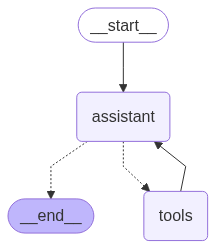

In [24]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

try:
    display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass


### 그래프 테스트

In [ ]:
example = {"input": 
                "user"
                """Send email to "myemail@gmail.com" with subject "Hello" and body "Hi there" """
        }

response = predict_react_agent_answer_verbose(example)
print(response['final_state']['assistant']['messages'].content)


--- Event ---
{'assistant': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-09-02T08:21:57.6666998Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1239490100, 'load_duration': 58091500, 'prompt_eval_count': 2219, 'prompt_eval_duration': 615650500, 'eval_count': 41, 'eval_duration': 554597300, 'model_name': 'qwen2.5:14b'}, id='run--3b9abe60-6d83-488a-bd7e-1c075659c3bf-0', tool_calls=[{'name': 'send_email', 'args': {'body': 'Hi there', 'subject': 'Hello', 'to': 'wjdah1727@gmail.com'}, 'id': '90fb04dd-2e02-44b1-abc5-eb0e27663d71', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2219, 'output_tokens': 41, 'total_tokens': 2260})}}

--- Event ---
{'tools': {'messages': [ToolMessage(content='{"success": true, "detail": "이메일 발송 성공"}', name='send_email', id='2fac4807-5973-4b4d-ab98-ab8f65840db4', tool_call_id='90fb04dd-2e02-44b1-abc5-eb0e27663d71')]}}

--- Event ---
{'assistant': {'messages': AIMessage(con